# Forecast The Global Household Electric Power Consumption

In [1]:
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sklearn
import xgboost as xgb


## Explore The Data

In [2]:
data = pd.read_csv("../data/household_power_consumption.txt", sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [3]:
data.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

There is 2075259 records from 2006-12-16 to 2010-11-26 with 25979 of missing records. We simply fill with mean-value.  

In [4]:
from sklearn.impute import SimpleImputer
imputer_na = SimpleImputer(strategy="mean")
data = pd.DataFrame(imputer_na.fit_transform(data), index=data.index, columns=data.columns)

In [5]:
data.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [6]:
# The min freq is too cruel for me. So, I resample it as the minute-averaged at hour frequency 

data = data.resample("H").mean()

In [7]:
data.shape

(34589, 7)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34589 entries, 2006-12-16 17:00:00 to 2010-11-26 21:00:00
Freq: H
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    34589 non-null  float64
 1   Global_reactive_power  34589 non-null  float64
 2   Voltage                34589 non-null  float64
 3   Global_intensity       34589 non-null  float64
 4   Sub_metering_1         34589 non-null  float64
 5   Sub_metering_2         34589 non-null  float64
 6   Sub_metering_3         34589 non-null  float64
dtypes: float64(7)
memory usage: 2.1 MB


The data has been downloaded from https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set
and the following is the **Attribute Information:**

1. **date**: Date in format dd/mm/yyyy  
2. **time**: time in format hh:mm:ss  
3. **globalactivepower**: household global minute-averaged active power (in kilowatt)  
4. **globalreactivepower**: household global minute-averaged reactive power (in kilowatt)  
5. **voltage**: minute-averaged voltage (in volt)  
6. **global_intensity**: household global minute-averaged current intensity (in ampere)  
7. **submetering1**: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).  
8. **submetering2**: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.  
9. **submetering3**: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner  

In [9]:
data.head(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


We focus on forecasting the Global_active_power here, which is the **true** or **real** or **actual power** dissipated in the circuit.

The final step of data preparation is create the decimal time columns. This is useful when we want to deal with time-dependent things.

In [10]:
from datetime import datetime as dt
import time

def toYearFraction(date):
    """convert date into decimal time"""
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch
    
    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [11]:
# create decimal_time column for time-dependent calculation
data = data.reset_index()
data = data.set_index("dt", drop=False)
data["decimal_time"] = data["dt"].apply(lambda x: toYearFraction(x))
del data["dt"]
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,decimal_time
dt,,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,2006.958105
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,2006.958219
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,2006.958333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,2006.958447
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,2006.958562


## Let's Forecast !

First of all, let's revise some concept of the time series.  

Time series can be decomposed as three components, which are **drift**, **seasonal**, and **noise**

$$ y(t) = \mathrm{drift} + \mathrm{seasonal} + \mathrm{noise}. $$

- **Drift**: An overall trend, such as 
$$ y(t) = \mu t. $$
Note that the trend no need to be a linear, it can be quadratic or polynomial or whatever! 

- **Seasonality**: A periodic behavior, such as
$$ y(t) = A\sin(2\pi ft) + B\cos(2\pi ft). $$
where, $f$ is the frequency

- **Noise**: The part of the time series remaining after removing drift and seasonality. It is the residual of a model containing drift and seasonality.

Our approach will be to identify the first two terms to create a baseline model, leaving behind the residuals or noise.

**The steps to time series forecasting:**
1. Plot the time series to see if there is any overall trends and seasonality.
1. Detrend the time series by removing drift and seasonality.
1. Fit a baseline model and calculate the residuals.
1. Analyze the resulting residuals and generate features from the residuals.
1. Train a machine learning model to forecast/predict residuals and add back the baseline model.

## Deal with the Drift

<AxesSubplot:xlabel='dt', ylabel='Minute average power kW'>

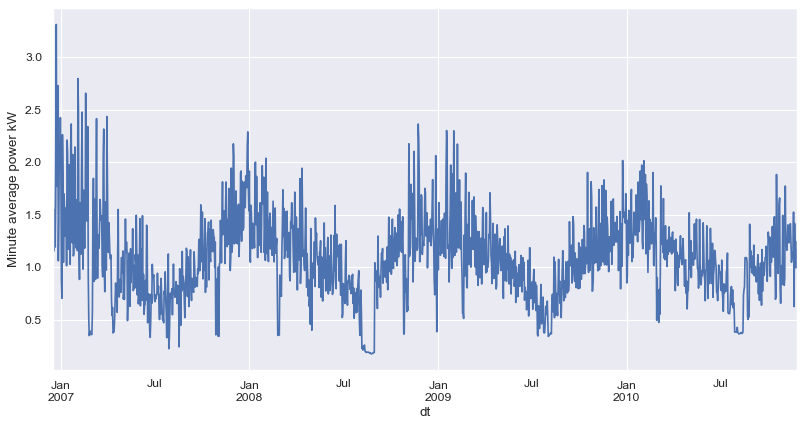

In [12]:
power = data['Global_active_power']
plt.figure(figsize=(12, 6), dpi=80)
plt.ylabel('Minute average power kW')
power.resample("D").mean().plot()

According to the plots, it's obvoiusly has a seasonal pattern, but I don't see any drift. However, we can create a simple model to capture drift, if it exists, even if we can't notice it.

In [13]:
# We can customize transformer to select the column of df
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnSelectTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, need_reshape=False):
        self.columns = columns
        self.need_reshape = need_reshape

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        if self.need_reshape:
            return X[self.columns].values.reshape(-1,1)
        else:
            return X[self.columns]

In [14]:
# Split train - test data by date cutoff 

def ts_train_test_split(df, cutoff, target):
    """Perform a train/test split on a data frame based on a cutoff date."""
    
    ind = df.index < str(cutoff)
    
    df_train = df.loc[ind]
    df_test = df.loc[~ind]
    y_train = df.loc[ind, target]
    y_test = df.loc[~ind, target]
    
    return df_train, df_test, y_train, y_test

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error

# perform train/test split
cutoff = 2010
df_train, df_test, y_train, y_test = ts_train_test_split(data, cutoff, 'Global_active_power')

# construct and train pipeline
drift_col = ColumnSelectTransformer("decimal_time", need_reshape=True)
poly = PolynomialFeatures(degree=1)

model = xgb.XGBRFRegressor()

drift_pipe = Pipeline([
    ("select_col", drift_col),
    ("drift", poly)
])
pipe = Pipeline([('drift_feature', drift_pipe),
                 ('regressor', model)])
pipe.fit(df_train, y_train)

# make predictions
y_pred = pipe.predict(data)
resd = power - y_pred
y_pred_test = pipe.predict(df_test)
print("Test set R^2: {:g}".format(pipe.score(df_test, y_test)))
print("Test set mean rmse: {:g}".format(np.sqrt(mean_squared_error(y_pred_test, y_test))))

Test set R^2: -0.00130818
Test set mean rmse: 0.767913


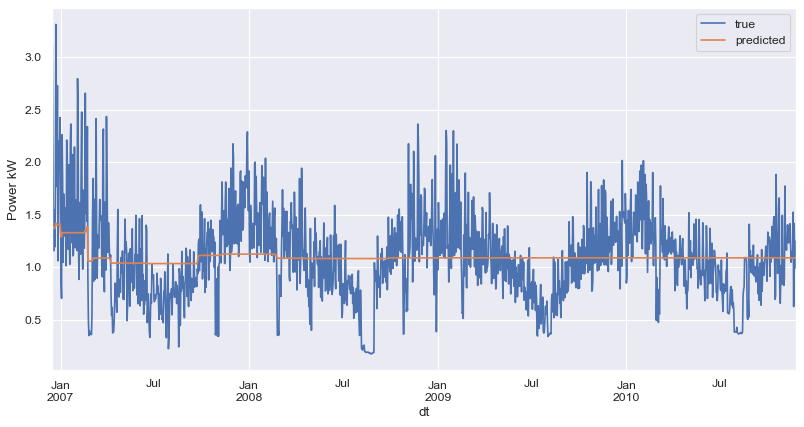

In [16]:
y_pred_df = pd.DataFrame(y_pred, index=data.index, columns=["pred_power"])
plt.figure(figsize=(12, 6), dpi=80)
plt.ylabel('Power kW')
power.resample("D").mean().plot()
y_pred_df["pred_power"].resample("D").mean().plot()
plt.legend(['true', 'predicted'])

<AxesSubplot:xlabel='dt', ylabel='Residuals Power kW'>

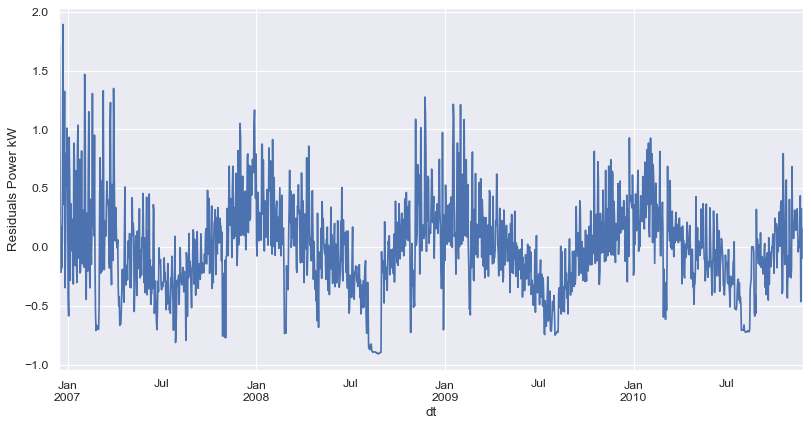

In [17]:
plt.figure(figsize=(12, 6), dpi=80)
plt.ylabel('Residuals Power kW')
resd.resample("D").mean().plot()

## Time to crack the seasonality !!

As your math teacher told you. _"Any signal can be represented as a linear superposition of sines and cosines of varying frequencies $f_n$ and amplitudes $A_n$ and $B_n$"_,

$$ y(t) = \sum_n \left(A_n \sin(2\pi f_n t) + B_n\cos(2 \pi f_n t) \right). $$

Sometime (most of the time), we want to know what is the dominant frequencies that make up a time series.

Here are when the **Fourier transform** comes to save our life.  

The Fourier transform  let us transforme our signal in the time domain into the frequency domain. Since we will be working with discrete data; the signal is sampled at discrete points in time, we will use the **discrete Fourier transform**. For $N$ uniformly sampled time series $y_n$, the transform is defined as

$$ Y_k = \sum^{N-1}_{n=0} y_n e^{-\frac{2\pi i}{N} kn}, $$

$$ Y_k = \sum^{N-1}_{n=0} y_n \left[\cos\left(\frac{2\pi i}{N} kn\right) - i\sin\left(\frac{2\pi i}{N} kn\right) \right], $$

and $i$ is the imaginary number. The term $Y_k$ is the Fourier transform value for a frequency of $k$ cycles in $N$ samples; it is a complex number that represents both the amplitude and phase for its respective sinusoidal component. The amplitude for the frequency $k/N$ is 

$$ |Y_k|/N = \frac{\sqrt{\mathrm{Re}(Y_k)^2 + \mathrm{Im}(Y_k)^2}}{N}. $$

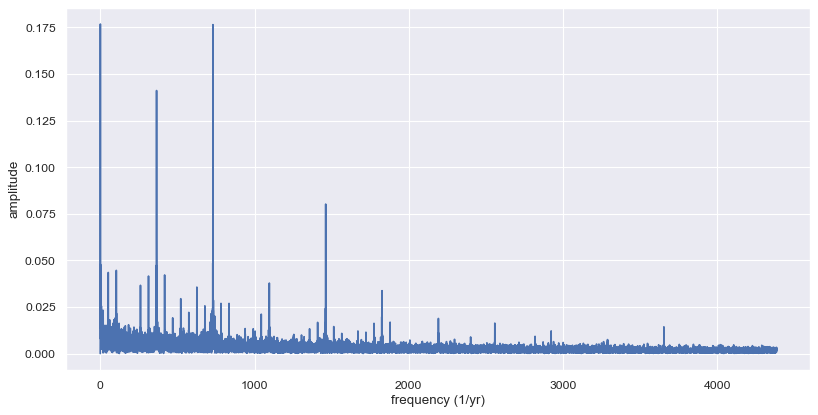

In [18]:
from scipy import fftpack

Y = fftpack.fft(power.values - power.mean())
t_span = toYearFraction(power.index[-1]) - toYearFraction(power.index[0])
f = np.linspace(0, len(Y), len(Y))/t_span

def plot_fft(fraction):
    plt.figure(figsize=(12, 6), dpi=80)
    plt.plot(f[:len(Y)//fraction], np.abs(Y[:len(Y)//fraction])/len(Y));
    plt.xlabel('frequency (1/yr)')
    plt.ylabel('amplitude');

plot_fft(2)

This plot shows the amplitude of each frequency. The greater amplitude means stronger domination of the frequency.

In [19]:
# get the most dominant frequencies
def most_dominant_fft(top_n, fraction):
    fft_top_list = zip(f[:len(Y)//fraction], np.abs(Y[:len(Y)//fraction])/len(Y))
    return sorted(fft_top_list, key=lambda t: t[1], reverse=True)[:top_n]

# This is the most 15 dominant frequencies
most_dominant_fft(15, 2)

[(1.0138008641394267, 0.1767292681736852),
 (730.4435226124571, 0.1764243157571791),
 (365.22176130622853, 0.14106699891050334),
 (730.6969728284919, 0.12371017739211304),
 (1461.1404954409488, 0.08015318650215446),
 (365.47521152226335, 0.061119829753613714),
 (730.1900723964222, 0.05931394969802912),
 (729.4297217483175, 0.04844643160050287),
 (2.0276017282788534, 0.047798664116586106),
 (364.2079604420891, 0.047308908863787365),
 (366.2355621703679, 0.04514354271556675),
 (104.42148900636097, 0.04459514732828523),
 (52.210744503180486, 0.04345883361660001),
 (417.432505809409, 0.04213707039004188),
 (313.011016803048, 0.04154316505225182)]

In [20]:
ff_list = [1, 2, 365, 730, 1461] # pick some

Add our finding in the model !

$$ y(t) = A + B\sin(2\pi f_1 t) + C\cos(2\pi f_1 t) + D\sin(2\pi f_2 t) + E\cos(2\pi f_2 t), $$

where $t$ in expressed in units of years.

Now, we got the most dominant frequencies that make up the series. I interpreted the numbers and found that it's a lot that made sense. The pattern of household consumption appears every year, every half year, every day, every half-day, and every quarter of a day. Next, let's create Fourier features and see is the residauls look better!

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

class FourierComponents(BaseEstimator, TransformerMixin):
    def __init__(self, freqs):
        """Create features based on sin(2*pi*f*t) and cos(2*pi*f*t)."""
        self.freqs = freqs
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        Xt = np.zeros((X.shape[0], 2*len(self.freqs)))
        
        for i, f in enumerate(self.freqs):

            Xt[:, 2*i]= np.cos(2*np.pi*f*X.values).reshape(-1)
            Xt[:, 2*i + 1] = np.sin(2*np.pi*f*X.values).reshape(-1)
    
        return Xt

In [22]:
# construct and train pipeline
from sklearn.pipeline import FeatureUnion

# perform train/test split
cutoff = 2010
df_train, df_test, y_train, y_test = ts_train_test_split(data, cutoff, 'Global_active_power')

# construct and train pipeline

trend_col = ColumnSelectTransformer("decimal_time", need_reshape=True)
poly = PolynomialFeatures(degree=1)
trend_pipe = Pipeline([('trend_col', trend_col),
                 ('drift', poly),
                 ])

fourier_col = ColumnSelectTransformer("decimal_time")
fourier = FourierComponents(ff_list)
seasonal_pipe = Pipeline([("fourier_col", fourier_col),
                    ("fourier", fourier)])


feature_union = FeatureUnion([
    ("trend_feature", trend_pipe),
    ("seasonal_feature", seasonal_pipe)
])

# construct and train pipeline
lr = LinearRegression()
model = xgb.XGBRFRegressor()

baseline = Pipeline([
    ('feature_union', feature_union),
    ('regressor', model)
])

baseline.fit(df_train, y_train)
# make predictions
y_pred = baseline.predict(data)
resd = power - y_pred

y_pred_test = baseline.predict(df_test)
print("Test set R^2: {:g}".format(baseline.score(df_test, y_test)))
print("Test set mean rmse: {:g}".format((np.sqrt(mean_squared_error(y_pred_test, y_test)) / y_test.mean())))

Test set R^2: 0.329405
Test set mean rmse: 0.591676


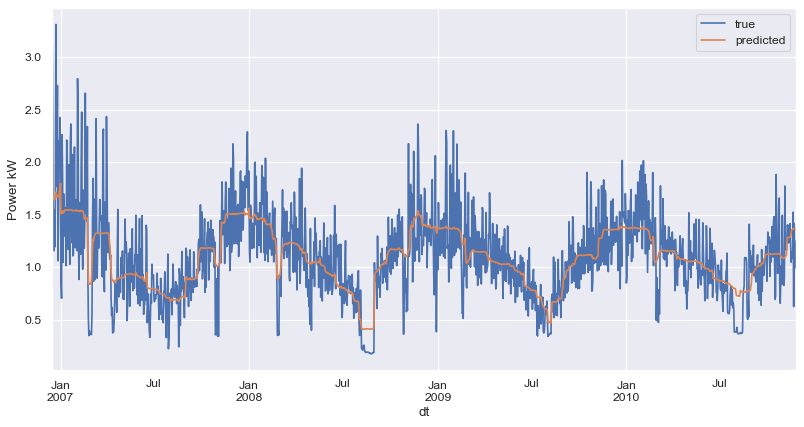

In [23]:
y_pred_df = pd.DataFrame(y_pred, index=data.index, columns=["pred_power"])
plt.figure(figsize=(12, 6), dpi=80)
plt.ylabel('Power kW')
power.resample("D").mean().plot()
y_pred_df["pred_power"].resample("D").mean().plot()
plt.legend(['true', 'predicted'])

<AxesSubplot:xlabel='dt', ylabel='Residuals Power kW'>

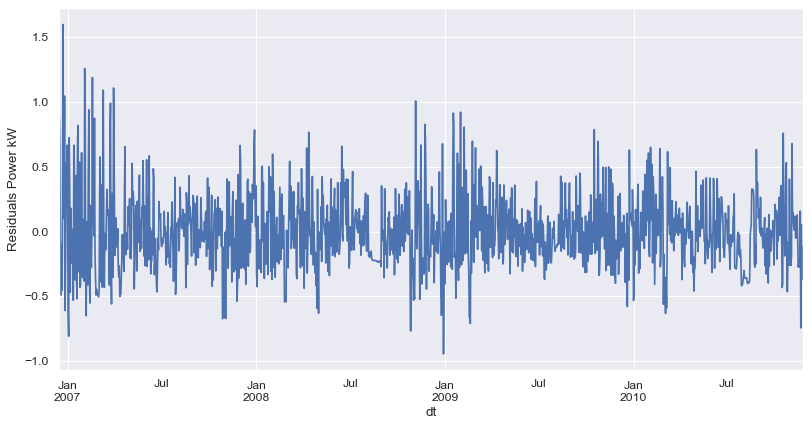

In [24]:
plt.figure(figsize=(12, 6), dpi=80)
plt.ylabel('Residuals Power kW')
resd.resample("D").mean().plot()

Wow, the seasonal is disappear now!

## Modeling noise

Particulary, past values of times series are correlated to current values.  This is known as **autocorrelation**

To understand the autocorrelation, we should think about:

* **Covariance**: A measure of _joint_ variability of two variables,
$$ \mathrm{cov}(X, Y) = E[(X - E[X])(Y - E[Y])] =  \frac{1}{N} \sum^{n}_{i=1}(x_i - E[X])(y_i - E[Y]). $$

* **Variance**: A measure of the variability of a variable with _itself_; the special case of the covariance,
$$ \mathrm{var}(X) =  \mathrm{cov}(X, X) = E[(X - E[X])^2] = \frac{1}{N} \sum^{n}_{i=1}(x_i - E[X])^2. $$ 

* **Standard Deviation**: The square root of the variance,
$$ \sigma_X = \sqrt{\mathrm{var}(X)}. $$

* **Correlation**: The normalized covariance that ranges from -1 to 1,
$$\rho(X, Y) = \frac{\mathrm{cov}(X, Y)}{\sigma_X \sigma_Y}. $$ 

Three important values and meanings of the correlation coefficient are:

1. If $\rho(X, Y) = 1$, then the two variables are completely linear correlated; an increase in one corresponds to a linear increase of the other.
1. If $\rho(X, Y) = 0$, then the two variables are uncorrelated. Higher values of one variable does not necessarily correspond to higher or lower values of the other.
1. If $\rho(X, Y) = -1$, then the two variables are completely linear anti-correlated; an increase in one corresponds to a linear decrease of the other.

With the correlation coefficient, we can now mathematically define and better understand the autocorrelation of a signal. The autocorrelation as a function of the duration of the lag is defined as

$$ R(\tau) =  \frac{\mathrm{cov}(y(t), y(t-\tau))}{\sigma_{y} \sigma_{y}} = \frac{\gamma(\tau)}{\sigma^2_{y}} = \rho(y(t), y(t-\tau)), $$

where $\tau$ is the duration of the lag/delay and $\gamma$ is the autocovariance function. Since we are working with discrete data, we can define the lag with respect to the number of time steps $k$,

$$ R(k) = \frac{\gamma(k)}{\sigma_{y}^2} = \rho(y_t, y_{t-k}). $$

**In conclusion the autocorrelation is just a correlation between present value and the past of itself (lag)**

***Let's see the correlation of our time series***

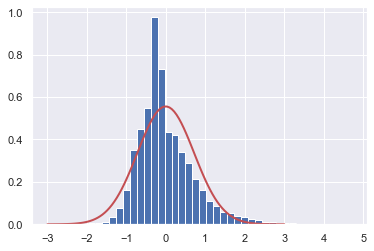

In [25]:
# I though all noises are random now

from scipy.stats import norm

mu = resd.mean()
sigma = resd.std(ddof=1)
dist = norm(mu, sigma)
x = np.linspace(-3, 3, 100)
f = dist.pdf(x)

resd.hist(bins=40, density=True)
plt.plot(x, f, '-r', linewidth=2);

(0.0, 100.0)

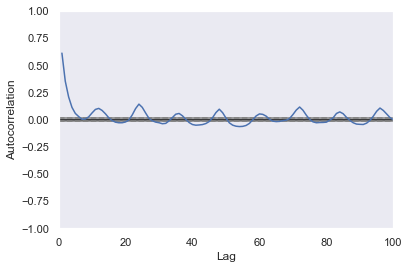

In [26]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(resd)
plt.xlim([0, 100])

(0.0, 24.0)

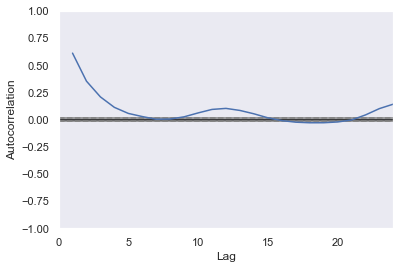

In [27]:
# Zoom in
autocorrelation_plot(resd)
plt.xlim([0, 24])

In [28]:
resd.autocorr(1)

0.611257252305366

In [29]:
resd.autocorr(2)

0.3533319696769358

In [30]:
resd.autocorr(3)

0.20847778692908733


Then, we will calculate **noisy features** from their's past statistic.

In [31]:
class ResidualFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, window=24):
        """Generate features based on window statistics of past noise/residuals."""
        self.window = window
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df = pd.DataFrame()
        df['residual'] = pd.Series(X, index=X.index)
        df['mean'] = df['residual'].rolling(window=self.window).mean()
        df['std'] = df['residual'].rolling(window=self.window).std()
        df['max'] = df['residual'].rolling(window=self.window).max()
        df['min'] = df['residual'].rolling(window=self.window).min()
        df['diff'] = df['residual'].diff().rolling(window=self.window).mean()
        df = df.fillna(method='bfill')
        
        return df

class LagsFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, lags=2):
        """Generate features based on past noise/residuals."""
        self.lags = lags
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df = pd.DataFrame()
        df['residual'] = pd.Series(X, index=X.index)
        for i in range(self.lags):
            step = i + 1
            df[f"lag_{step}"] = df['residual'].shift(step)
        return df.drop("residual", axis=1).fillna(method='bfill')

In [32]:
from sklearn.metrics import r2_score, mean_squared_error

# create and train residual model
resd_train = y_train - baseline.predict(df_train)
stat_residual_feats = ResidualFeatures(window=20)
lags_feats = LagsFeatures(lags=3)

residual_feats = FeatureUnion([
    ("stat_residual_feats",stat_residual_feats),
    ("lags_feats",lags_feats)
])

model = xgb.XGBRFRegressor()

residual_model = Pipeline([('residual_features', residual_feats), ('regressor', model)])
residual_model.fit(resd_train.iloc[:-24], resd_train.shift(-24).dropna())

# evaluate model
resd_pred = residual_model.predict(resd) # prediction for all time steps
resd_pred = pd.Series(resd_pred, index=data.index)
resd_pred = resd_pred.shift(10).dropna() # shift predicted values to matching time step
resd_pred_test = resd_pred.loc["2010":] # evaluate only on 2010 values
print("Residual test set R^2: {:g}".format(r2_score(resd.loc["2010":], resd_pred_test)))
print("Test set mean rmse: {:g}".format((np.sqrt(mean_squared_error(resd_pred_test, resd.loc["2010":])))))

Residual test set R^2: -0.0232774
Test set mean rmse: 0.635534


<AxesSubplot:xlabel='dt', ylabel='Residuals Power kW'>

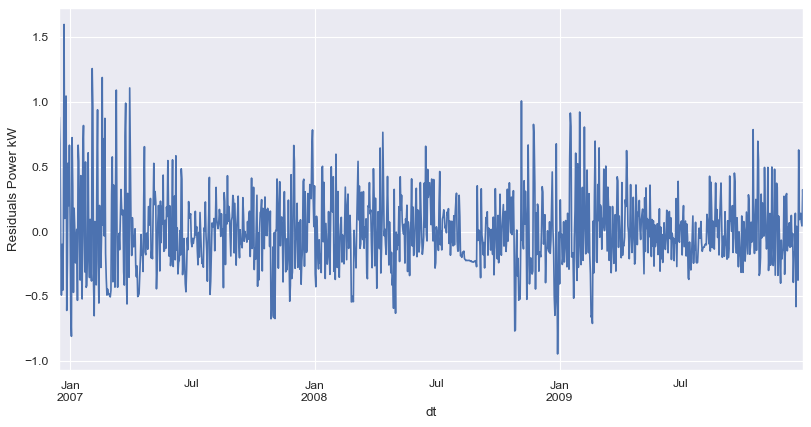

In [33]:
plt.figure(figsize=(12, 6), dpi=80)
plt.ylabel('Residuals Power kW')
resd_train.resample("D").mean().plot()

## Bring it all together

In [34]:
from sklearn.base import RegressorMixin

class FullModel(BaseEstimator, RegressorMixin):
    def __init__(self, baseline, residual_model, steps=24):
        """Combine a baseline and residual model to predict any number of steps in the future."""
        
        self.baseline = baseline
        self.residual_model = residual_model
        self.steps = steps
        
    def fit(self, X, y):
        self.baseline.fit(X, y)
        resd = y - self.baseline.predict(X)
        self.residual_model.fit(resd.iloc[:-self.steps], resd.shift(-self.steps).dropna())
                
        return self
    
    def predict(self, X):
        y_b = pd.Series(self.baseline.predict(X), index=X.index)
        resd = X['Global_active_power'] - y_b
        resd_pred = pd.Series(self.residual_model.predict(resd), index=X.index)
        resd_pred = resd_pred.shift(self.steps)
        y_pred = y_b + resd_pred
        
        return y_pred
    
# construct and train full model
full_model = FullModel(baseline, residual_model, steps=24)
full_model.fit(df_train, y_train)

# make predictions
y_pred = full_model.predict(data)
resd = power - y_pred
ind = resd["2010":].index
print("Test set R^2: {:g}".format(r2_score(power.loc[ind], y_pred.loc[ind])))
print("Test set rmse: {:g}".format((np.sqrt(mean_squared_error(power.loc[ind], y_pred.loc[ind])))))

Test set R^2: 0.345518
Test set rmse: 0.620836


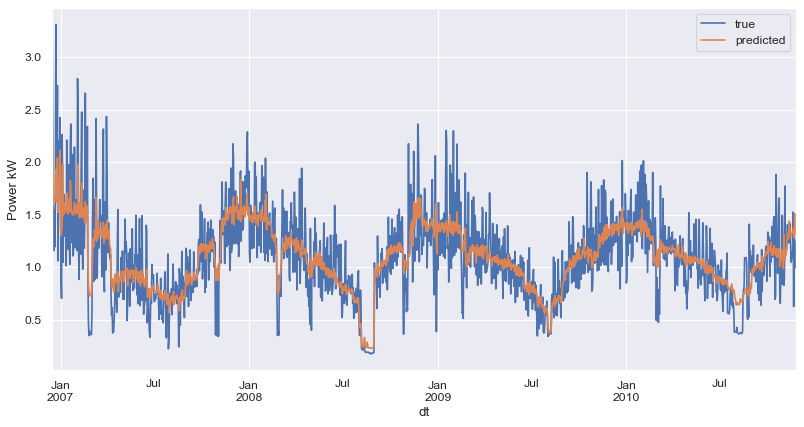

In [35]:
y_pred_df = pd.DataFrame(y_pred, index=data.index, columns=["pred_power"])
plt.figure(figsize=(12, 6), dpi=80)
plt.ylabel('Power kW')
power.resample("D").mean().plot()
y_pred_df["pred_power"].resample("D").mean().plot()
plt.legend(['true', 'predicted'])

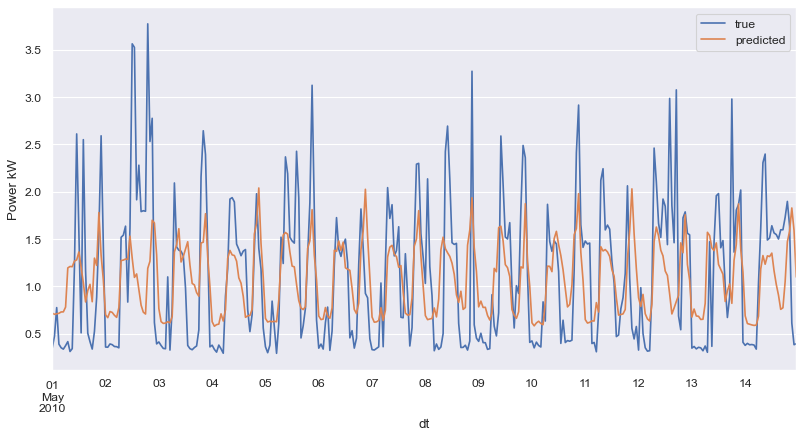

In [36]:
# Zoom in for some part of test set 
y_pred_df = pd.DataFrame(y_pred, index=data.index, columns=["pred_power"])
plt.figure(figsize=(12, 6), dpi=80)
plt.ylabel('Power kW')
power.loc["2010-05-01":"2010-05-14"].plot()
y_pred_df["pred_power"].loc["2010-05-01":"2010-05-14"].plot()
plt.legend(['true', 'predicted'])

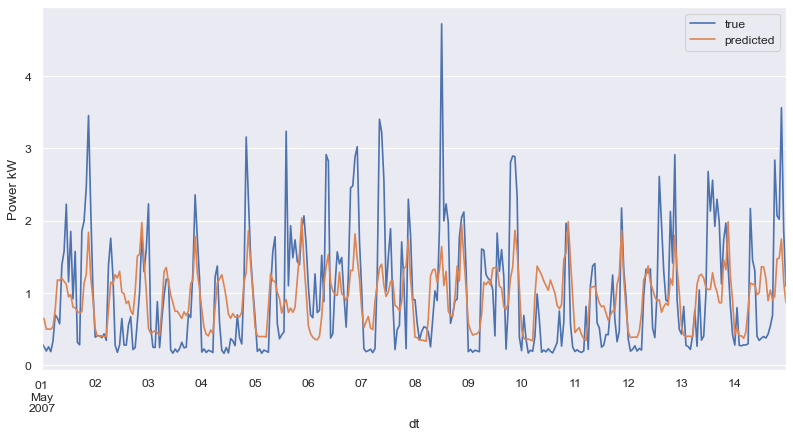

In [37]:
# Zoom in for some part of training set 
y_pred_df = pd.DataFrame(y_pred, index=data.index, columns=["pred_power"])
plt.figure(figsize=(12, 6), dpi=80)
plt.ylabel('Power kW')
power.loc["2007-05-01":"2007-05-14"].plot()
y_pred_df["pred_power"].loc["2007-05-01":"2007-05-14"].plot()
plt.legend(['true', 'predicted'])

<AxesSubplot:xlabel='dt', ylabel='Residuals Power kW'>

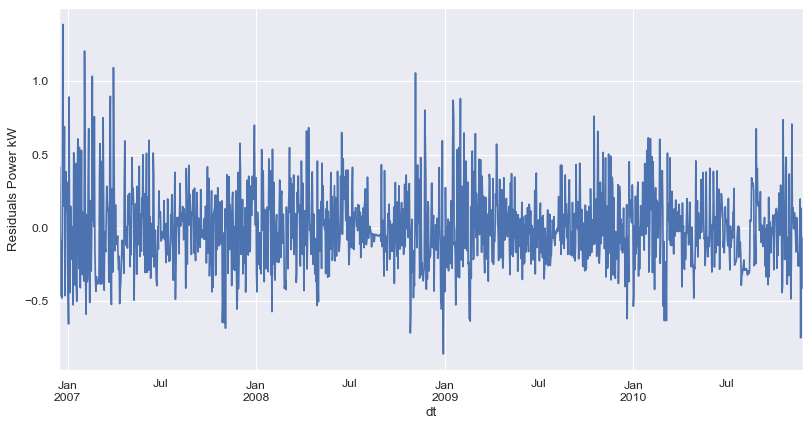

In [38]:
plt.figure(figsize=(12, 6), dpi=80)
plt.ylabel('Residuals Power kW')
resd.resample("D").mean().plot()

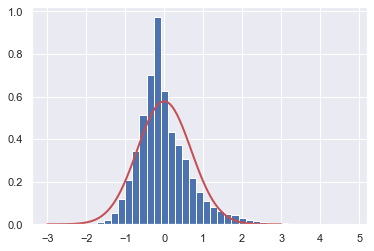

In [39]:
mu = resd.mean()
sigma = resd.std(ddof=1)
dist = norm(mu, sigma)
x = np.linspace(-3, 3, 100)
f = dist.pdf(x)

resd.hist(bins=40, density=True)
plt.plot(x, f, '-r', linewidth=2);

## Conclusion
We forecast the minute mean global active power, at hourly frequency, for the next 24 steps by decomposing the series into three parts, drift, seasonal, and noise. In the drift part, we generate a linear feature. For the seasonal part, we found the most dominant frequencies at every year, every half year, every day, every half-day, and every quarter of a day, using Fourier transform. Then, we generate FourierComponents features. All these features are combined to construct the baseline model and fit the training set using XGBRegressor. The R2 and rmse at this step are 0.32, and 0.59. After that, we try to model noise, using lags and past moving window statistics. After combining everything, the R2, and rmse are 0.34 and 0.62.